# Advanced Lane Finding

## Import Modules

In [20]:
import numpy as np
import cv2
import pickle
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Read in an image
image = mpimg.imread('signs_vehicles_xygrad.png')

## Camera Calibration

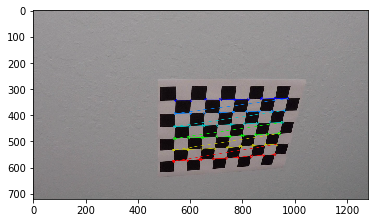

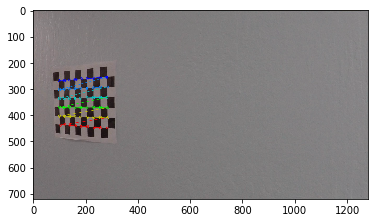

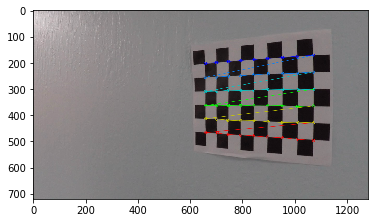

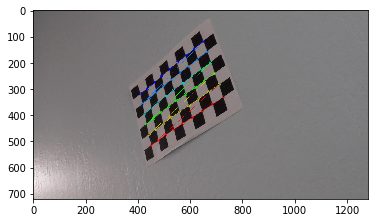

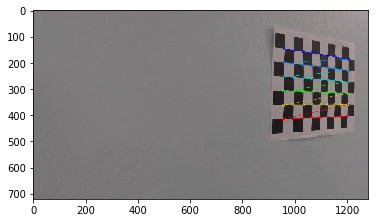

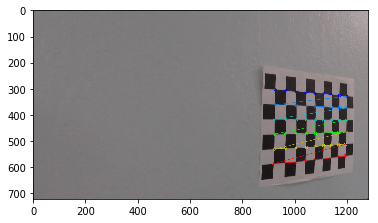

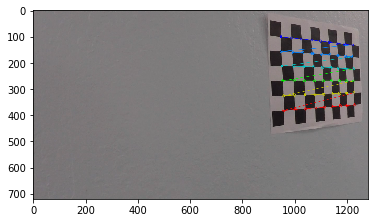

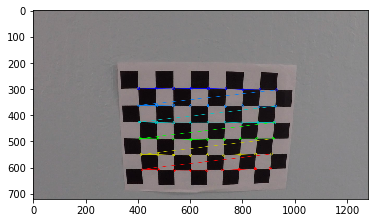

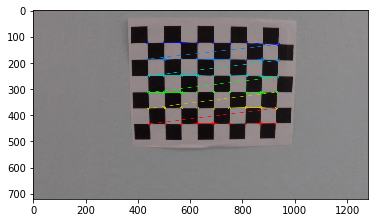

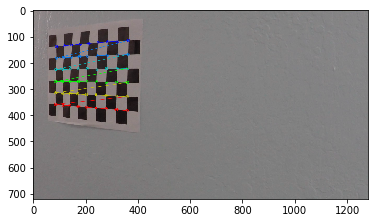

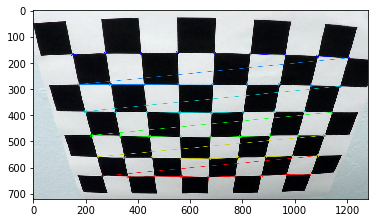

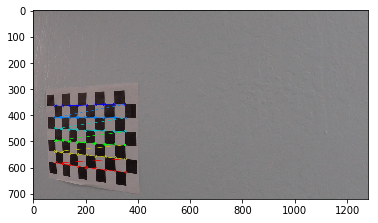

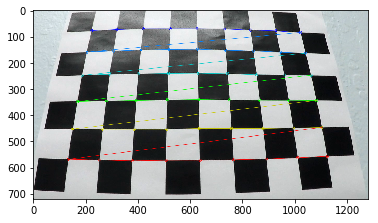

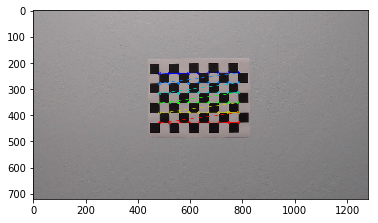

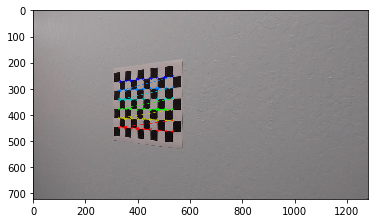

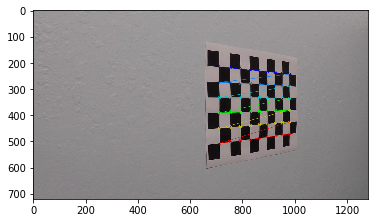

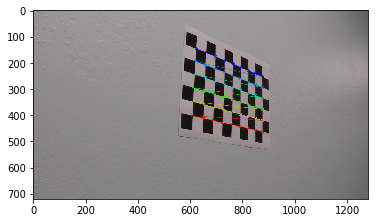

In [21]:
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny * nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
        plt.show()

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


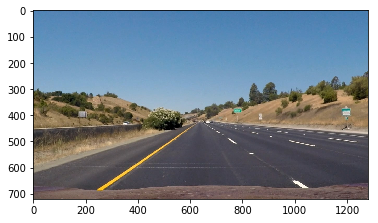

In [5]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)

plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

## Distortion Correction

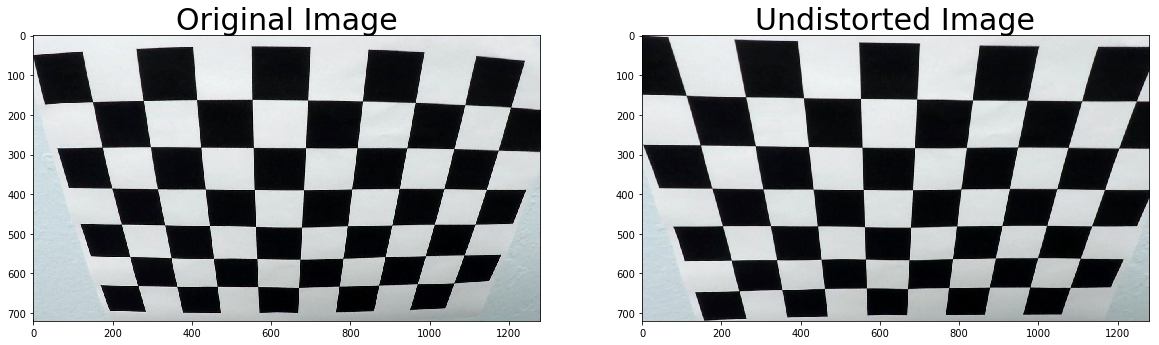

In [22]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Color/Gradient Threshold

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if  orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        raise 'orient not recognised'
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return grad_binary

In [7]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude
    mag_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * mag_sobelxy/np.max(mag_sobelxy))
    
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return mag_binary

In [8]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    gradient_dir = np.arctan2(abs_sobely, abs_sobelx)
        
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(gradient_dir)
    dir_binary[(gradient_dir >= thresh[0]) & (gradient_dir <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image    
    return dir_binary

In [33]:
# Choose a Sobel kernel size
ksize = 9 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(60, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(60, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.8, 1.2))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

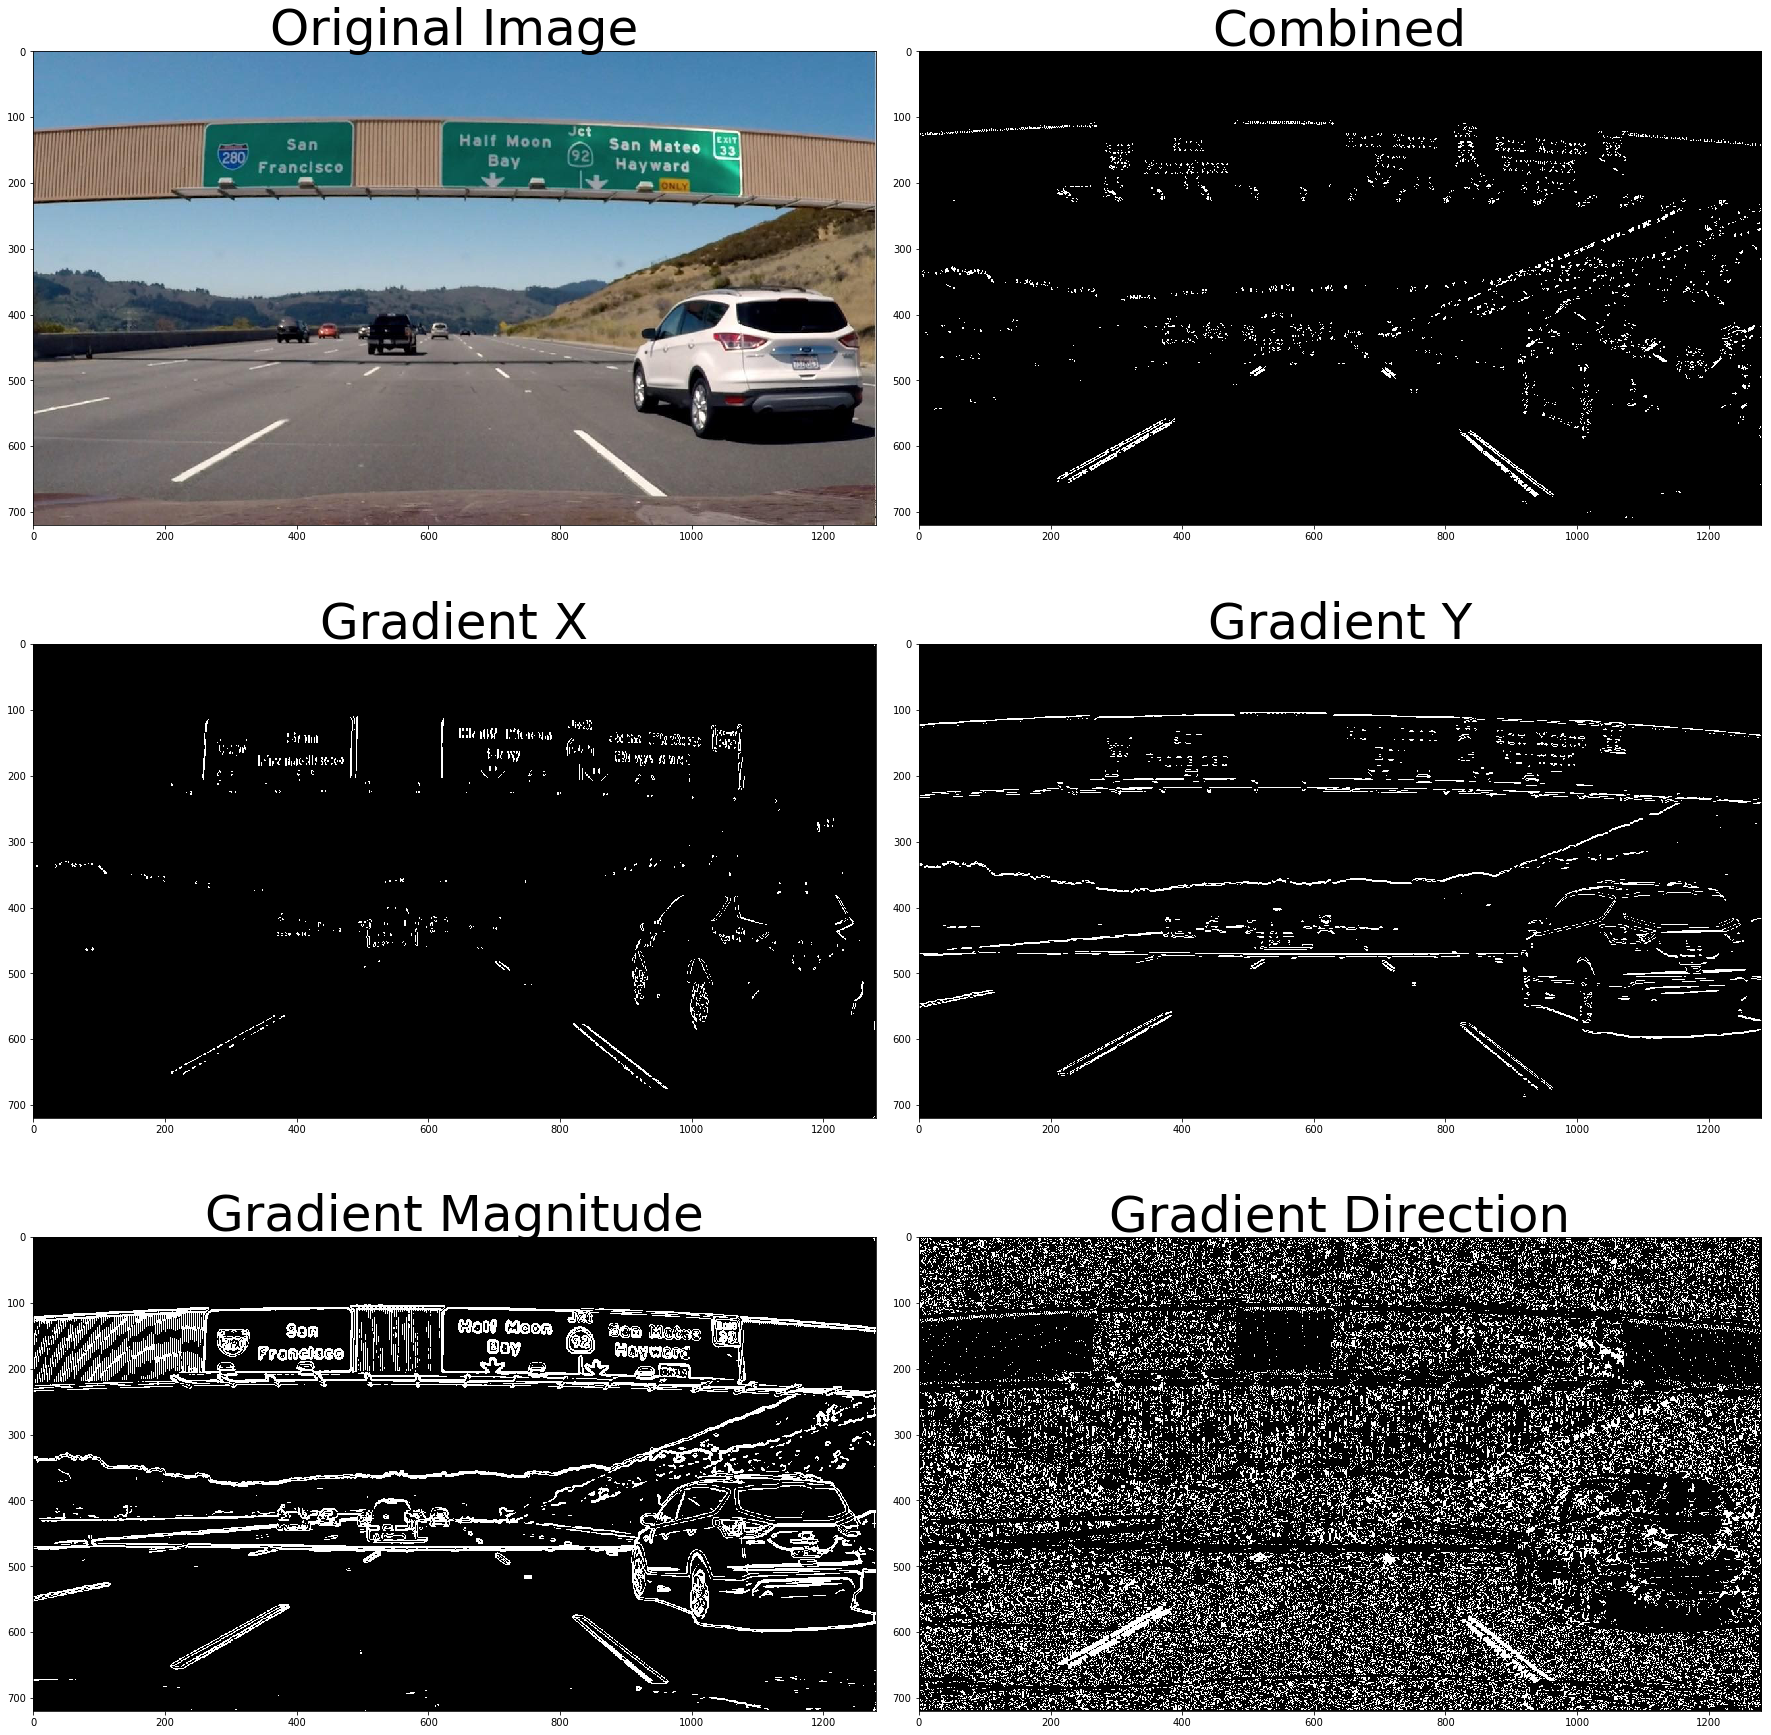

In [34]:
# Plot the result
f, ((a1, a2), (b1, b2), (c1, c2)) = plt.subplots(3, 2, figsize=(24, 27))
f.tight_layout()

a1.imshow(image)
a1.set_title('Original Image', fontsize=50)
a2.imshow(combined, cmap='gray')
a2.set_title('Combined', fontsize=50)

b1.imshow(gradx, cmap='gray')
b1.set_title('Gradient X', fontsize=50)
b2.imshow(grady, cmap='gray')
b2.set_title('Gradient Y', fontsize=50)

c1.imshow(mag_binary, cmap='gray')
c1.set_title('Gradient Magnitude', fontsize=50)
c2.imshow(dir_binary, cmap='gray')
c2.set_title('Gradient Direction', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image):
    return image

In [15]:
white_output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [00:27<00:00, 36.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 2.28 s, sys: 1.7 s, total: 3.98 s
Wall time: 28.7 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))